In [7]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [8]:
import matplotlib.pyplot as pyplot
import optuna as op
%matplotlib inline
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Utils.createICM import newCreateICM
from Utils.createURM import createURM2
from Utils.createURM import newCreateURM
from Utils.combineURMICM import combine

In [9]:
URM = createURM2()
ICM = newCreateICM()

C:\Users\Mike\PycharmProjects\recsys-challenge-2022-Pancini-Vitali\Utils\createURM.py:43: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('../Input/interactions_and_impressions.csv')


KeyboardInterrupt: 

In [ ]:
URM_train, URM_test = split_train_in_two_percentage_global_sample(URM, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

In [ ]:
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

In [78]:
URMICMCombined = combine(ICM, URM_train)

## Neighbors

In [79]:
x_tick = [10, 25, 40, 50, 100]
MAP_per_k = []

for topK in x_tick:

    recommender = ItemKNNCFRecommender(URMICMCombined.T)
    recommender.fit(shrink=0.0, topK=topK)

    result_df, _ = evaluator_validation.evaluateRecommender(recommender)

    MAP_per_k.append(result_df.loc[10]["MAP"])

ItemKNNCFRecommender: URM Detected 5 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 27968 (100.0%), 933.56 column/sec. Elapsed time 29.96 sec
EvaluatorHoldout: Processed 39007 (100.0%) in 20.47 sec. Users per second: 1906
ItemKNNCFRecommender: URM Detected 5 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 27968 (100.0%), 979.46 column/sec. Elapsed time 28.55 sec
EvaluatorHoldout: Processed 39007 (100.0%) in 20.53 sec. Users per second: 1900
ItemKNNCFRecommender: URM Detected 5 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 27968 (100.0%), 969.53 column/sec. Elapsed time 28.85 sec
EvaluatorHoldout: Processed 39007 (100.0%) in 20.89 sec. Users per second: 1867
ItemKNNCFRecommender: URM Detected 5 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to

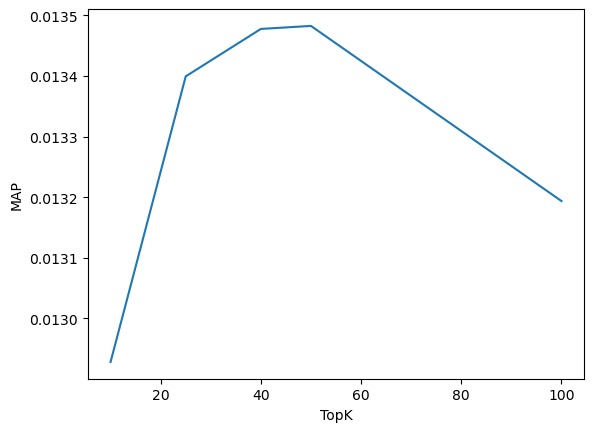

In [80]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

## Shrink

In [81]:
x_tick = [0, 10, 50, 100, 200]
MAP_per_shrinkage = []

for shrink in x_tick:

    recommender = ItemKNNCFRecommender(URMICMCombined.T)
    recommender.fit(shrink=shrink, topK=45)

    result_df, _ = evaluator_validation.evaluateRecommender(recommender)

    MAP_per_shrinkage.append(result_df.loc[10]["MAP"])

ItemKNNCFRecommender: URM Detected 5 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 27968 (100.0%), 975.41 column/sec. Elapsed time 28.67 sec
EvaluatorHoldout: Processed 39007 (100.0%) in 20.48 sec. Users per second: 1905
ItemKNNCFRecommender: URM Detected 5 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 27968 (100.0%), 1003.01 column/sec. Elapsed time 27.88 sec
EvaluatorHoldout: Processed 39007 (100.0%) in 20.44 sec. Users per second: 1908
ItemKNNCFRecommender: URM Detected 5 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 27968 (100.0%), 1001.09 column/sec. Elapsed time 27.94 sec
EvaluatorHoldout: Processed 39007 (100.0%) in 20.97 sec. Users per second: 1860
ItemKNNCFRecommender: URM Detected 5 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting 

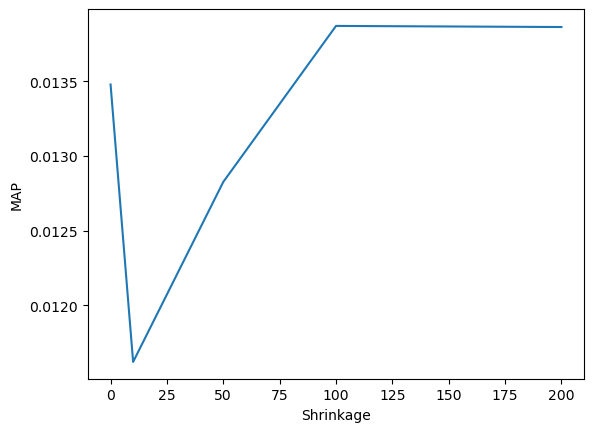

In [82]:
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

## OPTUNA optimization

In [83]:
# objective = represents the function that we need to minimize
# trial = optuna parameter that tries random values in a certain interval
recommender = ItemKNNCFRecommender(URM_train)
def objective(trial):
    topK = trial.suggest_int("topK", 175, 195)
    shrink = trial.suggest_float("shrink", 50, 56)
    recommender.fit(topK=topK, shrink=shrink)
    result_dict, _ = evaluator_validation.evaluateRecommender(recommender)

    return result_dict.loc[10]["MAP"]

ItemKNNCFRecommender: URM Detected 5 ( 0.0%) users with no interactions.


In [84]:
study = op.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2022-11-05 18:16:20,944] A new study created in memory with name: no-name-6c5aa9c9-9ea9-43a6-a90f-37600cb19781


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 27968 (100.0%), 927.32 column/sec. Elapsed time 30.16 sec
EvaluatorHoldout: Processed 39007 (100.0%) in 22.03 sec. Users per second: 1771


[I 2022-11-05 18:17:13,179] Trial 0 finished with value: 0.01382161362164979 and parameters: {'topK': 42, 'shrink': 112.47823731563625}. Best is trial 0 with value: 0.01382161362164979.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 27968 (100.0%), 990.01 column/sec. Elapsed time 28.25 sec
EvaluatorHoldout: Processed 39007 (100.0%) in 22.39 sec. Users per second: 1742


[I 2022-11-05 18:18:03,864] Trial 1 finished with value: 0.013832066568434656 and parameters: {'topK': 40, 'shrink': 115.47654588394641}. Best is trial 1 with value: 0.013832066568434656.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 27968 (100.0%), 967.83 column/sec. Elapsed time 28.90 sec
EvaluatorHoldout: Processed 39007 (100.0%) in 21.95 sec. Users per second: 1777


[I 2022-11-05 18:18:54,772] Trial 2 finished with value: 0.013893149418440042 and parameters: {'topK': 44, 'shrink': 116.71520771895881}. Best is trial 2 with value: 0.013893149418440042.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 27968 (100.0%), 990.08 column/sec. Elapsed time 28.25 sec
EvaluatorHoldout: Processed 39007 (100.0%) in 22.08 sec. Users per second: 1766


[I 2022-11-05 18:19:45,154] Trial 3 finished with value: 0.013883709720803333 and parameters: {'topK': 44, 'shrink': 107.35607829486699}. Best is trial 2 with value: 0.013893149418440042.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 27968 (100.0%), 991.41 column/sec. Elapsed time 28.21 sec
EvaluatorHoldout: Processed 39007 (100.0%) in 21.79 sec. Users per second: 1790


[I 2022-11-05 18:20:35,198] Trial 4 finished with value: 0.01381649956194296 and parameters: {'topK': 42, 'shrink': 107.22304165406828}. Best is trial 2 with value: 0.013893149418440042.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 27968 (100.0%), 995.23 column/sec. Elapsed time 28.10 sec
EvaluatorHoldout: Processed 39007 (100.0%) in 21.65 sec. Users per second: 1802


[I 2022-11-05 18:21:24,990] Trial 5 finished with value: 0.013830711500296711 and parameters: {'topK': 40, 'shrink': 116.20973434602718}. Best is trial 2 with value: 0.013893149418440042.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 27968 (100.0%), 976.57 column/sec. Elapsed time 28.64 sec
EvaluatorHoldout: Processed 39007 (100.0%) in 21.98 sec. Users per second: 1774


[I 2022-11-05 18:22:15,672] Trial 6 finished with value: 0.013884750437548927 and parameters: {'topK': 50, 'shrink': 107.56476511552702}. Best is trial 2 with value: 0.013893149418440042.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 27968 (100.0%), 988.29 column/sec. Elapsed time 28.30 sec
EvaluatorHoldout: Processed 39007 (100.0%) in 22.06 sec. Users per second: 1769


[I 2022-11-05 18:23:06,078] Trial 7 finished with value: 0.013844220471620955 and parameters: {'topK': 43, 'shrink': 114.6662349399051}. Best is trial 2 with value: 0.013893149418440042.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 27968 (100.0%), 985.38 column/sec. Elapsed time 28.38 sec
EvaluatorHoldout: Processed 39007 (100.0%) in 22.06 sec. Users per second: 1768


[I 2022-11-05 18:23:56,568] Trial 8 finished with value: 0.01390557901491866 and parameters: {'topK': 45, 'shrink': 109.0486866286725}. Best is trial 8 with value: 0.01390557901491866.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 27968 (100.0%), 976.86 column/sec. Elapsed time 28.63 sec
EvaluatorHoldout: Processed 39007 (100.0%) in 22.89 sec. Users per second: 1704


[I 2022-11-05 18:24:48,135] Trial 9 finished with value: 0.013894223706693567 and parameters: {'topK': 47, 'shrink': 113.28310884005074}. Best is trial 8 with value: 0.01390557901491866.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 27968 (100.0%), 970.54 column/sec. Elapsed time 28.82 sec
EvaluatorHoldout: Processed 39007 (100.0%) in 21.89 sec. Users per second: 1782


[I 2022-11-05 18:25:38,903] Trial 10 finished with value: 0.01385350858881276 and parameters: {'topK': 47, 'shrink': 100.25053961133851}. Best is trial 8 with value: 0.01390557901491866.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 27968 (100.0%), 983.49 column/sec. Elapsed time 28.44 sec
EvaluatorHoldout: Processed 39007 (100.0%) in 22.26 sec. Users per second: 1753


[I 2022-11-05 18:26:29,636] Trial 11 finished with value: 0.013884024072195722 and parameters: {'topK': 47, 'shrink': 111.0196499974539}. Best is trial 8 with value: 0.01390557901491866.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 27968 (100.0%), 963.65 column/sec. Elapsed time 29.02 sec
EvaluatorHoldout: Processed 39007 (100.0%) in 21.98 sec. Users per second: 1775


[I 2022-11-05 18:27:20,675] Trial 12 finished with value: 0.013850998864265995 and parameters: {'topK': 47, 'shrink': 103.3131733550909}. Best is trial 8 with value: 0.01390557901491866.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 27968 (100.0%), 983.63 column/sec. Elapsed time 28.43 sec
EvaluatorHoldout: Processed 39007 (100.0%) in 22.08 sec. Users per second: 1767


[I 2022-11-05 18:28:11,240] Trial 13 finished with value: 0.01394296953619667 and parameters: {'topK': 49, 'shrink': 119.70030097668956}. Best is trial 13 with value: 0.01394296953619667.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 27968 (100.0%), 972.49 column/sec. Elapsed time 28.76 sec
EvaluatorHoldout: Processed 39007 (100.0%) in 22.12 sec. Users per second: 1764


[I 2022-11-05 18:29:02,166] Trial 14 finished with value: 0.013920683141528402 and parameters: {'topK': 50, 'shrink': 109.86382990819409}. Best is trial 13 with value: 0.01394296953619667.


In [85]:
topK = study.best_params['topK']
shrink = study.best_params['shrink']

In [6]:
recommender = ItemKNNCFRecommender(URM_train)
recommender.fit(shrink=53.0, topK=185)
result_df, _ = evaluator_test.evaluateRecommender(recommender)
result_df

Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 809.83 column/sec. Elapsed time 30.26 sec
EvaluatorHoldout: Processed 41308 (100.0%) in 27.70 sec. Users per second: 1491


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.051922,0.06987,0.060524,0.024824,0.033011,0.162364,0.075162,0.055894,0.335649,0.199303,...,0.992289,0.333061,0.992289,0.102962,9.910954,0.994396,0.204605,0.734815,3.470055,0.351586
